# Setup and Helper Functions

In [107]:
%matplotlib inline

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json
import ipywidgets as widgets

from matplotlib import pyplot as plt

sns.set_style(style="darkgrid")

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_colwidth', None)

In [109]:
def multiplot_from_generator(g, num_columns):
    next(g)
    
    figsize = (15, 15/num_columns)
    
    try:
        while True:
            plt.figure(figsize=figsize)
            for col in range(num_columns):
                ax = plt.subplot(1, num_columns, col+1)
                next(g)
    except StopIteration:
        pass

In [110]:
import geopy.distance
moscow_center = [55.751244, 37.618423]

def construct_features(data):
    
    # replacing longitude and latitude with distance in km
    coordinates = data[['latitude', 'longitude']].to_numpy()
    dist = [geopy.distance.distance(moscow_center, coordinate).km for coordinate in coordinates]
    data['distance'] = dist
    
    data['top_floor'] = data['floor'] == data['stories']
    data['top_floor'] = data['top_floor'].astype(int)
    data['age'] = 2021 - data['constructed']
    data["bathrooms"] = data.bathrooms_shared + data.bathrooms_private
    for ind, row in data.iterrows():
        data.at[ind, "elevator"] = row.elevator_passenger == 1 or row.elevator_service == 1
    data['elevator'] = data['elevator'].astype(int)
    
    return data

In [111]:
def compute_bearing(c1, c2):
    y = np.sin(c2[1] - c1[1]) * np.cos(c2[0])
    x = np.cos(c1[0]) * np.sin(c2[0]) - np.sin(c1[0]) * np.cos(c2[0]) * np.cos(c2[1] - c1[1])
    rad = np.arctan2(y, x)
    # const brng = (θ*180/Math.PI + 360) % 360
    bearing = ((rad * 180 / np.pi) + 360) % 360
    return bearing

In [112]:
def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='autumn', column='price', title='Moscow apartment price by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

In [113]:
def compute_directional_data(data):
    for ind, row in data.iterrows():
        bearing = compute_bearing(moscow_center, [row["latitude"], row["longitude"]])
        data.at[ind, "bearing"] = bearing
        if 0 <= bearing <= 22.5 or 337.5 < bearing <= 360:
            direction = 0 # N
        elif 22.5 < bearing <= 67.5:
            direction = 1 # NE
        elif 67.5 < bearing <= 112.5:
            direction = 2 # E
        elif 112.5 < bearing <= 157.5:
            direction = 3 # SE
        elif 157.5 < bearing <= 202.5:
            direction = 4 # S
        elif 202.5 < bearing <= 247.5:
            direction = 5 # SW
        elif 247.5 < bearing <= 292.5:
            direction = 6 # W
        else:
            direction = 7 # NW
        data.at[ind, "direction"] = direction
    return data

In [114]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_scatter(x, y, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z)
    return ax

In [115]:
def one_hot_encode(data, categories, orig_var, remove_org=True):
    for k, category in categories.items():
        data[category] = (data[orig_var] == k).astype(int)
    if remove_org:
        data.drop(orig_var, axis=1, inplace=True)
    return data

In [116]:
def log_transform(data, features):
    for feature in features:
        data["log_{}".format(feature)] = np.log1p(data[feature])
    return data

# Load Data

In [117]:
apartments_train = pd.read_csv('data/apartments_train.csv')
buildings_train = pd.read_csv('data/buildings_train.csv')
apartments_test = pd.read_csv('data/apartments_test.csv')
buildings_test = pd.read_csv('data/buildings_test.csv')

# load meta info
with open('data/apartments_meta.json') as f:
    apartments_meta = json.load(f)
    
with open('data/buildings_meta.json') as f:
    buildings_meta = json.load(f)

meta_info = apartments_meta + buildings_meta

Merge building and apartment data

In [118]:
train = pd.merge(
    apartments_train, 
    buildings_train.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)
test = pd.merge(
    apartments_test, 
    buildings_test.set_index('id'), 
    how='left', 
    left_on='building_id', 
    right_index=True
)

In [119]:
train.head()

,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,0,3.0,7139520.0,59.2,12.5,31.0,2.0,2.0,NaN,2.65,0.0,2.0,0.0,1.0,NaN,NaN,NaN,1.0,4076,1.0,55.544046,37.478055,11.0,Бунинские Луга ЖК,к2.5/2,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
1,1,NaN,10500000.0,88.0,14.2,48.0,18.0,3.0,1.0,NaN,2.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
2,2,3.0,9019650.0,78.5,22.5,40.8,12.0,3.0,NaN,2.65,0.0,2.0,1.0,1.0,NaN,NaN,NaN,1.0,5176,1.0,55.663299,37.515335,6.0,Саларьево Парк ЖК,38,2021.0,3.0,15.0,0.0,1.0,1.0,1.0,NaN,NaN
3,3,NaN,10500000.0,88.0,14.0,48.0,18.0,3.0,NaN,NaN,0.0,2.0,1.0,1.0,0.0,1.0,2.0,1.0,1893,0.0,55.861282,37.666647,2.0,улица Радужная,14к3,2010.0,3.0,25.0,0.0,1.0,1.0,1.0,NaN,0.0
4,4,NaN,13900000.0,78.0,17.0,35.0,7.0,2.0,1.0,2.90,1.0,0.0,1.0,1.0,0.0,1.0,3.0,1.0,6604,0.0,55.590785,37.451438,11.0,улица Сервантеса,1к3,2017.0,2.0,15.0,0.0,1.0,1.0,1.0,0.0,0.0


In [120]:
test.head()

,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,street,address,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
0,23285,NaN,71.4,NaN,NaN,2.0,1.0,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,1.0,5148,0.0,55.762247,37.549040,0.0,2-я Черногрязская улица,6к3,2017.0,2.0,20.0,1.0,1.0,1.0,NaN,1.0,0.0
1,23286,NaN,54.0,4.0,50.0,4.0,1.0,NaN,3.00,NaN,NaN,1.0,0.0,NaN,NaN,3.0,1.0,1290,0.0,55.591467,37.452651,11.0,улица Сервантеса,3к2,2017.0,2.0,15.0,0.0,1.0,1.0,0.0,0.0,0.0
2,23287,3.0,39.4,19.6,11.2,10.0,1.0,NaN,2.65,1.0,0.0,1.0,0.0,NaN,NaN,NaN,1.0,681,1.0,55.617017,37.413718,11.0,Саларьево Парк ЖК,27,2021.0,3.0,9.0,0.0,1.0,1.0,1.0,NaN,NaN
3,23288,NaN,60.9,NaN,NaN,5.0,2.0,1.0,NaN,1.0,0.0,0.0,1.0,NaN,NaN,0.0,1.0,4261,0.0,55.569052,37.479510,11.0,улица Александры Монаховой,23,2014.0,2.0,17.0,1.0,1.0,0.0,NaN,1.0,3.0
4,23289,NaN,34.0,9.0,17.0,14.0,1.0,NaN,2.75,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,7530,0.0,55.518041,37.343829,11.0,улица 3-я Нововатутинская,13к1,2016.0,2.0,17.0,0.0,1.0,1.0,NaN,1.0,0.0


# Exploratory Data Analysis

## Meta Information

In [121]:
import json

def print_meta_info():
    
    df_data = []
    for entry in meta_info:
        nan_count_train, nan_count_test = np.NaN, np.NaN
        data_type = entry["name"]
        if data_type in train:
            nan_count_train = len(train[train[data_type].isna()])
        if data_type in test:
            nan_count_test = len(test[test[data_type].isna()])
        row = [entry["name"], entry["type"], entry["desc"], nan_count_train, nan_count_test]
        df_data.append(row)
    
    df = pd.DataFrame(df_data, columns=["name", "type", "desc", "nan_count_train", "nan_count_test"])
    return df

meta_df = print_meta_info()
meta_df

,name,type,desc,nan_count_train,nan_count_test
0,id,integer_id,Unique ID for apartment,0,0.0
1,seller,categorical,The type of apartment seller,8830,3942.0
2,price,real,The listed price of the apartment (TARGET),0,NaN
3,area_total,real,Total area of the apartment,0,0.0
4,area_kitchen,real,Total kitchen area in the apartment,4721,2233.0
5,area_living,real,Total living space area in the apartment,3882,2019.0
6,floor,integer,Primary building floor of the apartment,0,0.0
7,rooms,integer,Number of rooms in the apartment,0,0.0
8,layout,categorical,Overal apartment layout,17642,7368.0
9,ceiling,real,Ceiling height in the apartment,11093,5018.0


<AxesSubplot:title={'center':'Fraction of NaN values in the test set'}>

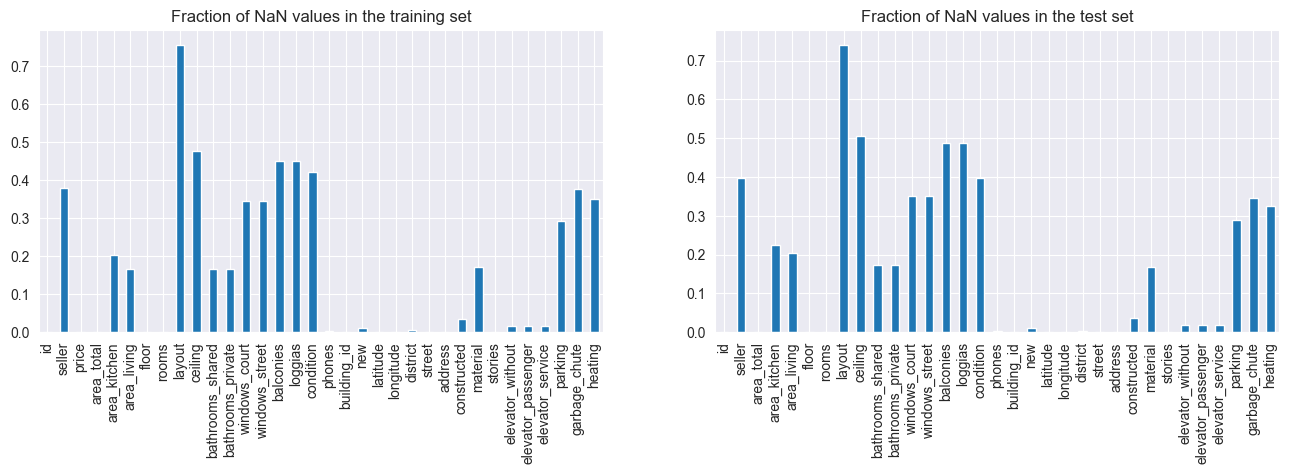

In [122]:
fig, (ax1, ax2) = plt.subplots(figsize=(16, 4), ncols=2, dpi=100)
train.isna().mean().plot.bar(ax=ax1, title='Fraction of NaN values in the training set')
test.isna().mean().plot.bar(ax=ax2, title='Fraction of NaN values in the test set')

**EDA insight:** Several features in both the training and test contain multiple NaN values. The distribution of NaN values appears to be similar in both datasets. However, the test data also has two rows with missing longitude and latitude values.

## Statistics

In [123]:
print("Number of training samples: {}".format(train.shape[0]))
print("Number of test samples: {}".format(test.shape[0]))
print("Number of features: {}".format(train.shape[1]))

Number of training samples: 23285
Number of test samples: 9937
Number of features: 34


In [124]:
print("Train data statistics")
train.describe()

Train data statistics


,id,seller,price,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,23285.000000,14455.000000,2.328500e+04,23285.000000,18564.000000,19403.000000,23285.000000,23285.000000,5643.000000,12192.000000,19413.000000,19413.000000,15213.000000,15213.000000,12765.000000,12765.000000,13475.000000,23205.000000,23285.000000,23021.000000,23285.000000,23285.000000,23155.000000,22491.000000,19313.000000,23285.000000,22928.000000,22928.000000,22928.000000,16497.000000,14474.000000,15124.000000
mean,11642.000000,1.875683,2.355617e+07,74.450999,12.552279,38.741367,8.969594,2.189349,1.039695,3.268374,0.737547,0.662855,0.797147,0.468678,0.556365,0.673090,1.270501,1.162293,4844.089156,0.337692,55.728337,37.583425,4.654848,2002.729581,2.203956,17.608933,0.392620,0.929867,0.743109,0.572589,0.806411,0.176012
std,6721.944845,1.089518,5.264393e+07,58.671373,6.565686,31.398480,8.322039,1.076130,0.351507,10.802728,0.781173,0.716888,0.402137,0.499034,0.641257,0.664779,1.017037,0.456937,2790.676698,0.472933,0.101831,0.150181,3.155835,22.948365,1.021101,11.216638,0.488344,0.255376,0.436928,0.549630,0.395124,0.566275
min,0.000000,0.000000,9.000000e+05,9.300000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.211430,36.864371,0.000000,1855.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5821.000000,1.000000,7.490000e+06,42.000000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2426.000000,0.000000,55.664837,37.497827,2.000000,1989.000000,2.000000,9.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,11642.000000,2.000000,1.064500e+07,59.800000,10.700000,30.900000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4772.000000,0.000000,55.738622,37.571938,5.000000,2013.000000,2.000000,16.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,17463.000000,3.000000,2.050000e+07,84.800000,15.300000,45.300000,12.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,7340.000000,1.000000,55.797458,37.671085,7.000000,2020.000000,3.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,23284.000000,3.000000,2.600000e+09,2181.000000,100.000000,900.000000,95.000000,6.000000,2.000000,340.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9735.000000,1.000000,56.006507,37.950668,11.000000,2023.000000,6.000000,95.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


**EDA insight:** There is a significant difference between the 75% percentile and the maximum value for the price, area_total, area_kitchen, area_living, floor, rooms, ceiling, loggias, balconies, and stories features, suggesting the presence of outliers. These need to be handled.

In [125]:
print("Test data statistics")
test.describe()

Test data statistics


,id,seller,area_total,area_kitchen,area_living,floor,rooms,layout,ceiling,bathrooms_shared,bathrooms_private,windows_court,windows_street,balconies,loggias,condition,phones,building_id,new,latitude,longitude,district,constructed,material,stories,elevator_without,elevator_passenger,elevator_service,parking,garbage_chute,heating
count,9937.000000,5995.000000,9937.000000,7704.000000,7918.000000,9937.000000,9937.000000,2569.000000,4919.000000,8220.000000,8220.000000,6449.000000,6449.000000,5102.000000,5102.000000,5978.000000,9897.000000,9937.000000,9828.000000,9935.000000,9935.000000,9912.000000,9563.000000,8266.000000,9937.000000,9757.000000,9757.000000,9757.000000,7070.000000,6511.000000,6707.000000
mean,28253.000000,1.805838,75.144219,12.874883,39.500515,9.184160,2.202878,1.036201,3.725885,0.776642,0.611922,0.809273,0.438518,0.584673,0.632301,1.259284,1.175003,4694.767032,0.302503,55.710977,37.562880,4.656275,2002.239569,2.236632,18.107578,0.428513,0.924567,0.746438,0.556577,0.764552,0.140152
std,2868.709146,1.087742,56.359318,6.878015,33.145228,7.963073,1.107315,0.334674,15.915162,0.811608,0.709386,0.392905,0.496244,0.645422,0.669174,1.041879,0.462727,2772.449218,0.459365,0.810385,2.441444,3.156144,23.635988,1.063680,10.725279,0.494889,0.264102,0.435072,0.578640,0.424311,0.515819
min,23285.000000,0.000000,13.000000,1.200000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,17.141734,-61.790500,0.000000,1860.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25769.000000,1.000000,42.400000,8.200000,20.000000,3.000000,1.000000,1.000000,2.650000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2145.000000,0.000000,55.669772,37.492455,2.000000,1988.000000,2.000000,10.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,28253.000000,2.000000,59.600000,10.800000,31.000000,7.000000,2.000000,1.000000,2.800000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,4728.000000,0.000000,55.738449,37.568920,5.000000,2014.000000,2.000000,17.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,30737.000000,3.000000,86.000000,16.000000,45.400000,13.000000,3.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,6983.000000,1.000000,55.798905,37.662843,7.000000,2019.000000,3.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,33221.000000,3.000000,1175.000000,63.600000,528.000000,69.000000,6.000000,2.000000,350.000000,4.000000,4.000000,1.000000,1.000000,4.000000,4.000000,3.000000,2.000000,9734.000000,1.000000,56.001625,132.768097,11.000000,2022.000000,6.000000,87.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000


In [126]:
train = construct_features(train)

**EDA insight:** There are some latitude and longitude values in the test data indicating a location far away from moscow.

In [127]:
features = train.columns[train.columns != "price"]
def plot_price_feature_relation():
    for feature in features:
        yield
        sns.scatterplot(x=feature, y="price", data=train)

# multiplot_from_generator(plot_price_feature_relation(), 3)

**EDA insight**:
1. area_total has a high correlation with the price. It would be interesting to see if the correlation increases if only houses that are close to the city center (i.e. not further than 10kms) are considered. The same applies to area_living.
2. It would be interesting to see if there are some streets where the house prices tend to be higher than in other streets (similar to monopoly).
3. For houses built after 1990, the house prices tend to increase with a lower age, whereas it is the opposite for houses built before 1990. If the house was built before 1990, the older it is, the more expensive it gets.
4. The distance certainly appears to play a role. If the houses are further away than 15kms from the city center, the prices tend to be very low. However, the variance is quite high for the houses even if they are close to the image center. The reason for this needs to be investigated. It may be due to the age of the building.
5. It would be interesting to see how the age and distance behave with respect to the price. For instance, do houses with a low distance but high age tend to be cheaper?
6. Could there be a relation between the age and the number of stories as well as the price? For example, do new buildings tend to have more floors than old buildings and if so, does this have a positive correlation with the price?
7. There is a high variability between the prices in some districts? What may be the cause of this? Can it be related to the age?
8. Do buildings that are close to each other have similar prices? E.g., if there the neighbouring building tends to be expensive, is the other building also expensive?

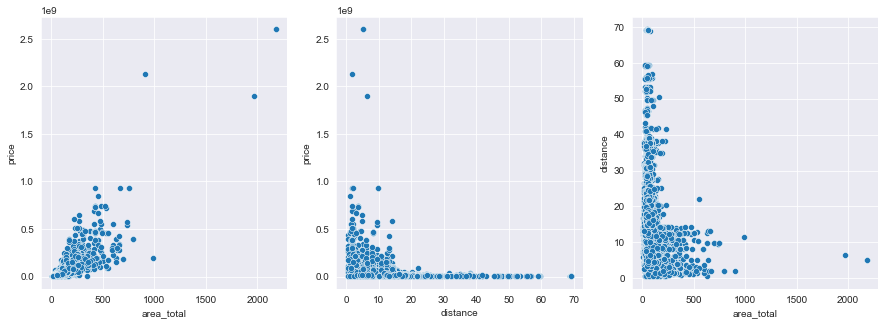

In [128]:
plt.show()
def area_total_distance_price():
    d = train
    yield
    sns.scatterplot(x="area_total", y="price", data=d)
    yield
    sns.scatterplot(x="distance", y="price", data=d)
    yield
    sns.scatterplot(x="area_total", y="distance", data=d)

multiplot_from_generator(area_total_distance_price(), num_columns=3)

**EDA insight**: Houses further away from the center have a rather low total area than those close to the center.
**EDA insight**: Considering the price per square meter could give further insight.

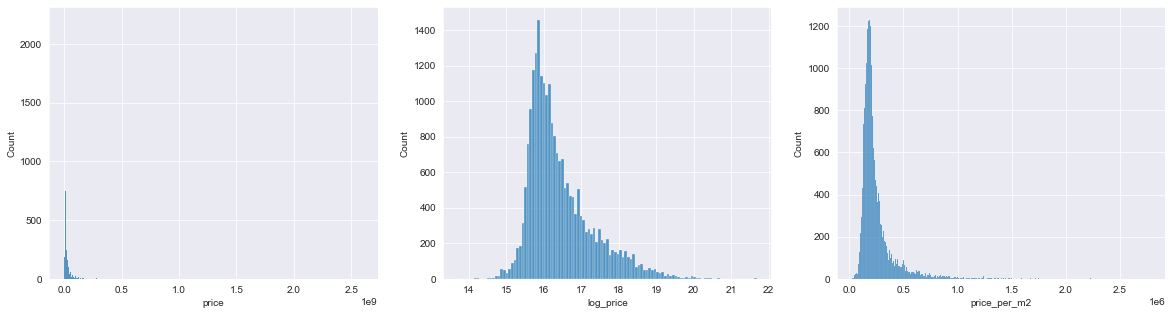

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
sns.histplot(data=train["price"], ax=ax[0])
train["log_price"] = np.log1p(train["price"])
sns.histplot(data=train["log_price"], ax=ax[1])
train["price_per_m2"] = train["price"] / train["area_total"]
sns.histplot(data=train["price_per_m2"], ax=ax[2])
plt.show()

**EDA insight:** As we can see, the unadjusted price is significantly right skewed. While computing the price per square meter looks a bit better, a log transformation of the price is even better.

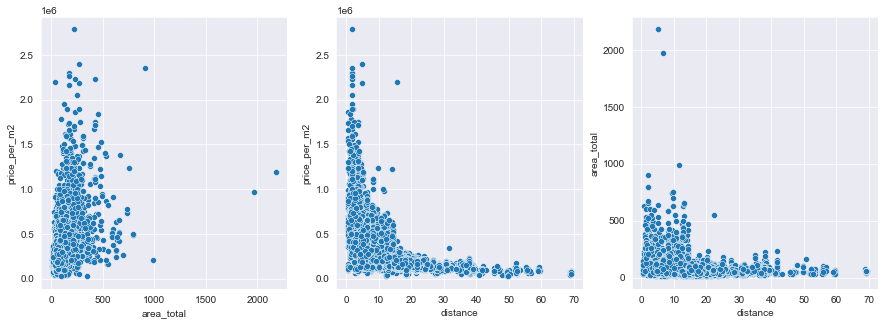

In [130]:
def area_total_distance_price_per_m2():
    d = train
    yield
    sns.scatterplot(x="area_total", y="price_per_m2", data=d)
    yield
    sns.scatterplot(x="distance", y="price_per_m2", data=d)
    yield
    sns.scatterplot(x="distance", y="area_total", data=d)

multiplot_from_generator(area_total_distance_price_per_m2(), num_columns=3)

**EDA insight:** The m2 price increases significantly with a shorter distance and indicates a clearer relationship than the price alone. However, there is still a strong variability which needs to be further investigated. What distinguishes cheap houses that are close to the center from expensive ones? Age? Number of stories? The street they are placed in? The price of other houses in the vicinity?

Possible features of interest:
* Distance to schools, shopping and entertainment opportunities, as well as recreational centers
* Proximity to public transport and highways
* neighbourhood comps, i.e., clusterings of the homes

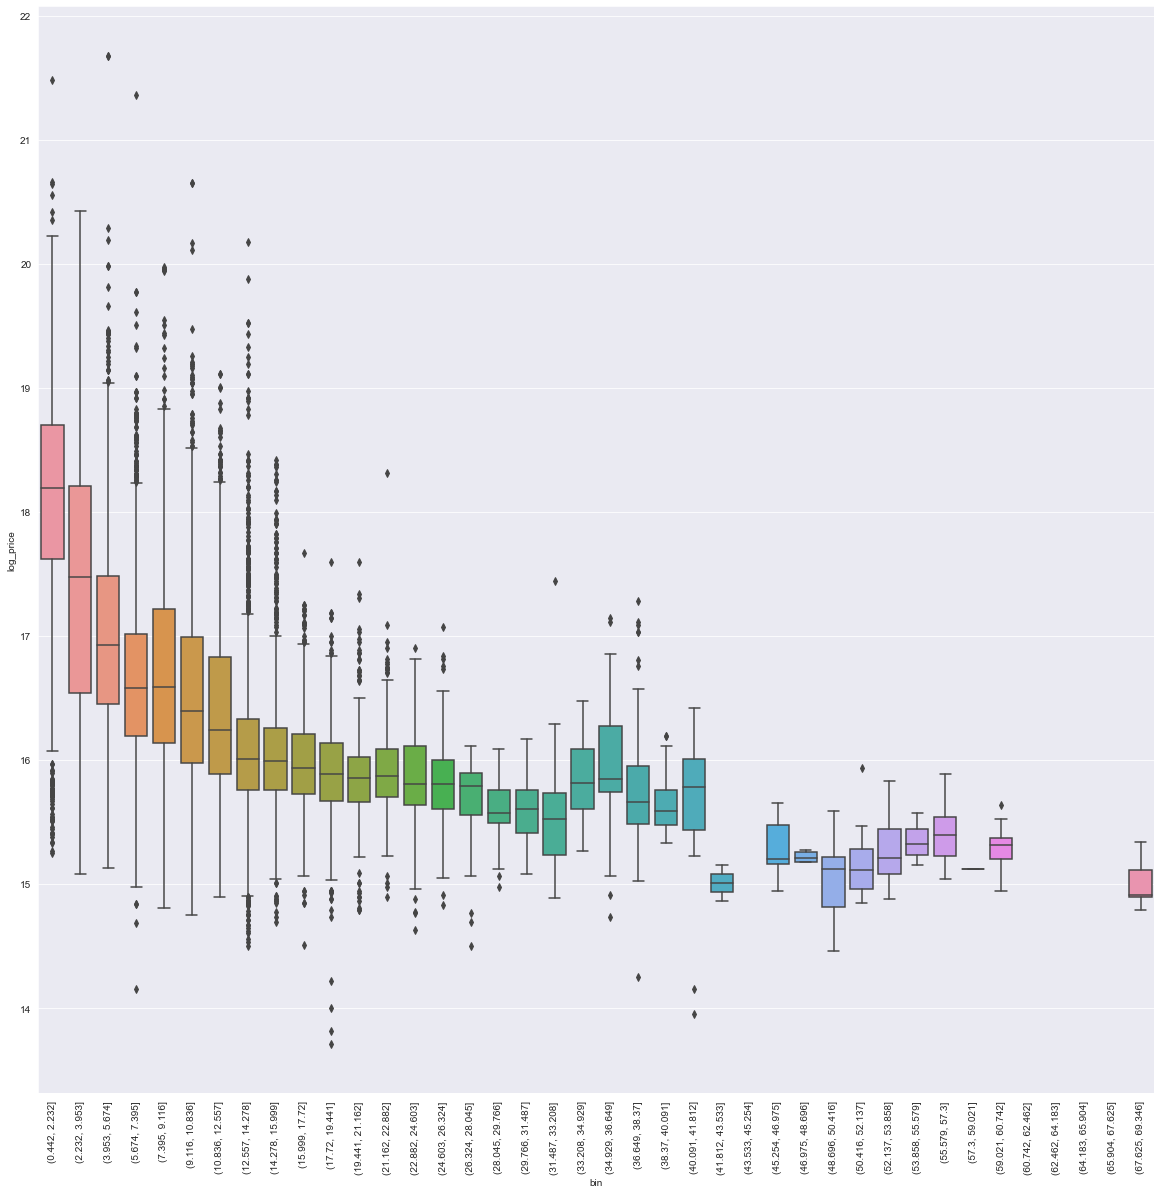

In [131]:
plt.figure(figsize=(20,20))
d = train
d["bin"], bins = pd.cut(d["distance"], bins=40, retbins=True)
ax = sns.boxplot(data=d, x="bin", y="log_price")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

**EDA insight:** The boxplot illustrates that there is a negative correlation between the log_price and the distance. However, there are several outliers in the bins with apartments closer to the city.

In [132]:
train = compute_directional_data(train)

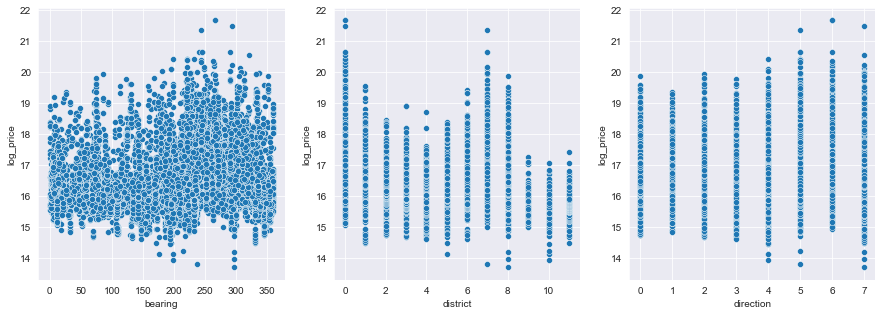

In [133]:
d = train
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.scatterplot(x="bearing", y="log_price", data=d, ax=ax[0])
sns.scatterplot(x="district", y="log_price", data=d, ax=ax[1])
sns.scatterplot(x="direction", y="log_price", data=d, ax=ax[2])
plt.show()

(<AxesSubplot:title={'center':'Moscow apartment log_price by location'}, xlabel='longitude', ylabel='latitude'>,
 <matplotlib.colors.Normalize at 0x13ad98d30>)

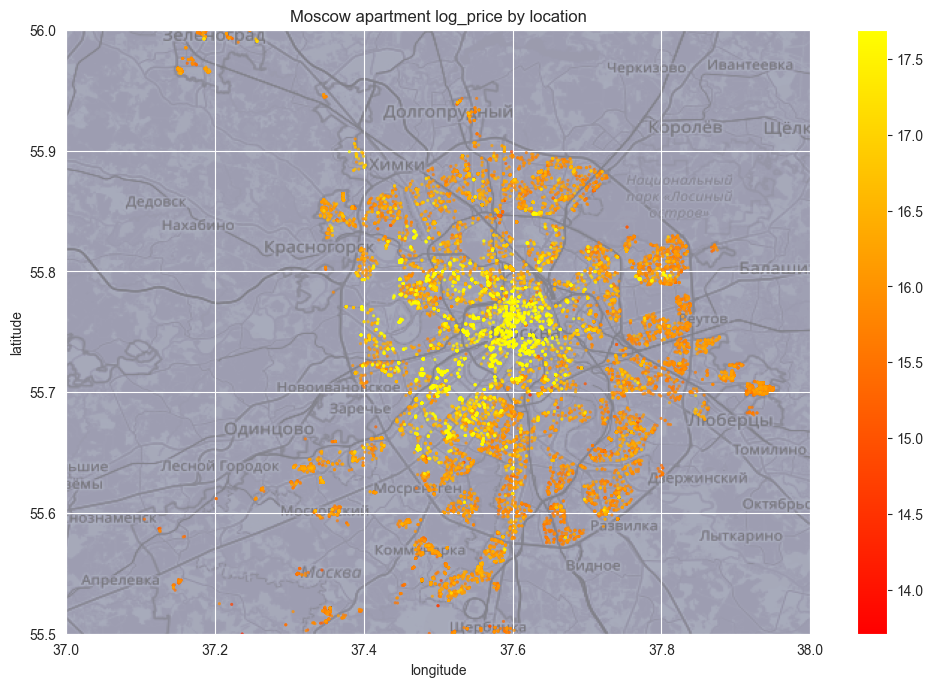

In [134]:
d = train
plot_map(data=d, column="log_price", title="Moscow apartment log_price by location")

**EDA insight:** Apartments that are in the center (0), west (7) and north-west (8) district have a greater log price variation than other districts. This difference can also be observed in the bearing (210 - 310) and direction (W - 6, NW - 7) plots and on the map plot.

0.6511642203709398


<AxesSubplot:xlabel='bathrooms', ylabel='log_price'>

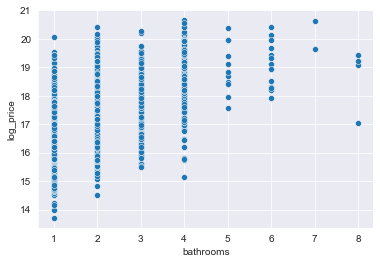

In [135]:
train["bathrooms"] = train.bathrooms_shared + train.bathrooms_private
d = train
print(d["bathrooms"].corr(d["log_price"]))
sns.scatterplot(x="bathrooms", y="log_price", data=d)

**EDA insight:** Number of bathrooms (shared or private) seem to have a positive effect on the log price.

Correlation area_total: 0.7825645168629933 | Correlation log_area_total: 0.8754840271438106


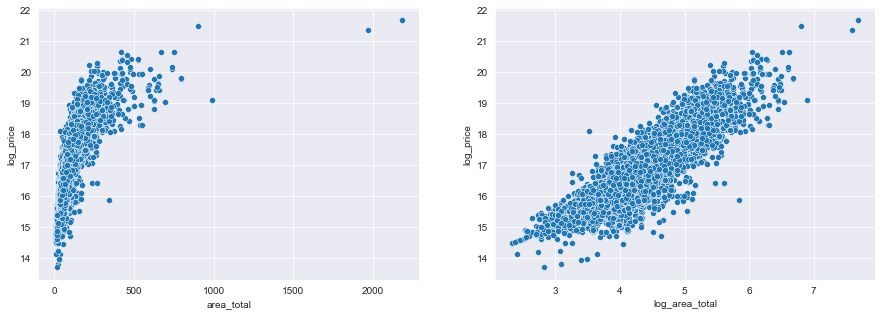

In [136]:
d = train.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_total", y="log_price", data=d, ax=ax[0])
d["log_area_total"] = np.log1p(d["area_total"])
sns.scatterplot(x="log_area_total", y="log_price", data=d, ax=ax[1])
print("Correlation area_total: {} | Correlation log_area_total: {}".format(d["area_total"].corr(d["log_price"]), d["log_area_total"].corr(d["log_price"])))

Correlation area_living: 0.7496293729728276 | Correlation log_area_living: 0.7091494404484565


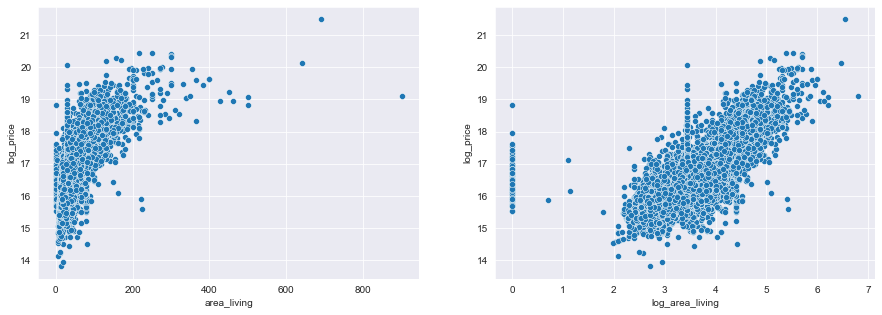

In [137]:
d = train.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_living", y="log_price", data=d, ax=ax[0])
d["log_area_living"] = np.log1p(d["area_living"])
sns.scatterplot(x="log_area_living", y="log_price", data=d, ax=ax[1])
print("Correlation area_living: {} | Correlation log_area_living: {}".format(d["area_living"].corr(d["log_price"]), d["log_area_living"].corr(d["log_price"])))

Correlation area_kitchen: 0.517460817836073 | Correlation log_area_kitchen: 0.521042228030699


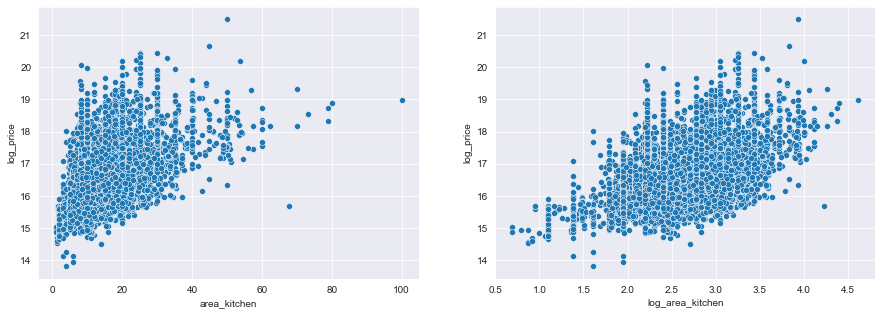

In [138]:
d = train.copy()
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="area_kitchen", y="log_price", data=d, ax=ax[0])
d["log_area_kitchen"] = np.log1p(d["area_kitchen"])
sns.scatterplot(x="log_area_kitchen", y="log_price", data=d, ax=ax[1])
print("Correlation area_kitchen: {} | Correlation log_area_kitchen: {}".format(d["area_kitchen"].corr(d["log_price"]), d["log_area_kitchen"].corr(d["log_price"])))

**EDA insight:** The log transformed area_total has a significantly higher correlation than the area_total parameter.

Correlation distance: -0.5344713194808199 | Correlation log_distance: -0.613751320604497


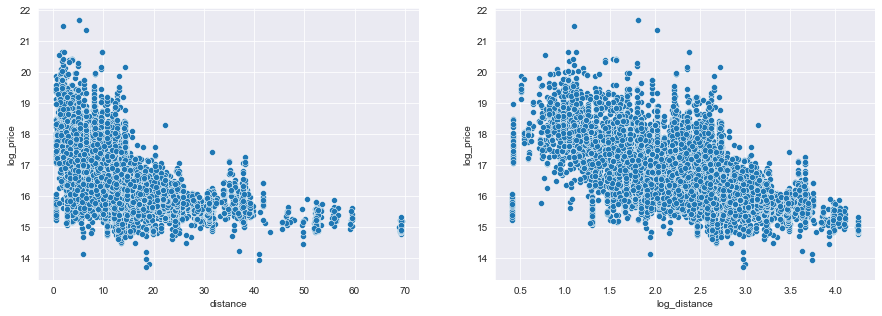

In [139]:
d = train.copy()
d["log_distance"] = np.log1p(d["distance"])
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(x="distance", y="log_price", data=d, ax=ax[0])
sns.scatterplot(x="log_distance", y="log_price", data=d, ax=ax[1])
print("Correlation distance: {} | Correlation log_distance: {}".format(d["distance"].corr(d["log_price"]), d["log_distance"].corr(d["log_price"])))

**EDA insight:** Performing a log transformation on the distance slightly increased the correlation with the log price since the distance was slightly skewed.

In [140]:
print("Skewness in training data:")
skew_feats = train.skew().sort_values(ascending=False)
pd.DataFrame({'Skew': skew_feats}).T

Skewness in training data:


/var/folders/qj/3xgy61cn4896krzkbpyn7gth0000gn/T/ipykernel_12373/2914573080.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  skew_feats = train.skew().sort_values(ascending=False)


,ceiling,price,area_total,area_living,price_per_m2,heating,top_floor,floor,stories,area_kitchen,bathrooms,distance,age,log_price,bathrooms_shared,bathrooms_private,balconies,loggias,rooms,new,phones,layout,elevator_without,district,condition,parking,windows_street,building_id,id,seller,longitude,bearing,direction,latitude,material,elevator_service,constructed,windows_court,garbage_chute,elevator,elevator_passenger
Skew,26.90155,19.152175,8.610355,5.319536,3.95057,3.824381,3.292655,2.790601,2.27116,2.207571,2.023348,1.738205,1.476935,1.255021,0.990077,0.970663,0.934573,0.857511,0.804358,0.68645,0.590888,0.57412,0.439809,0.291343,0.285369,0.228894,0.125547,0.022041,0.0,-0.268167,-0.29218,-0.297066,-0.353066,-0.450969,-0.514593,-1.112906,-1.476935,-1.478035,-1.551179,-3.040358,-3.36684


**EDA insight:** Some features have a high skewness, such as ceiling, price, area_total, etc. Skewness may cause issues and should be handled, i.e., by applying a log transformation.

## Feature Relations

### Correlation

<AxesSubplot:>

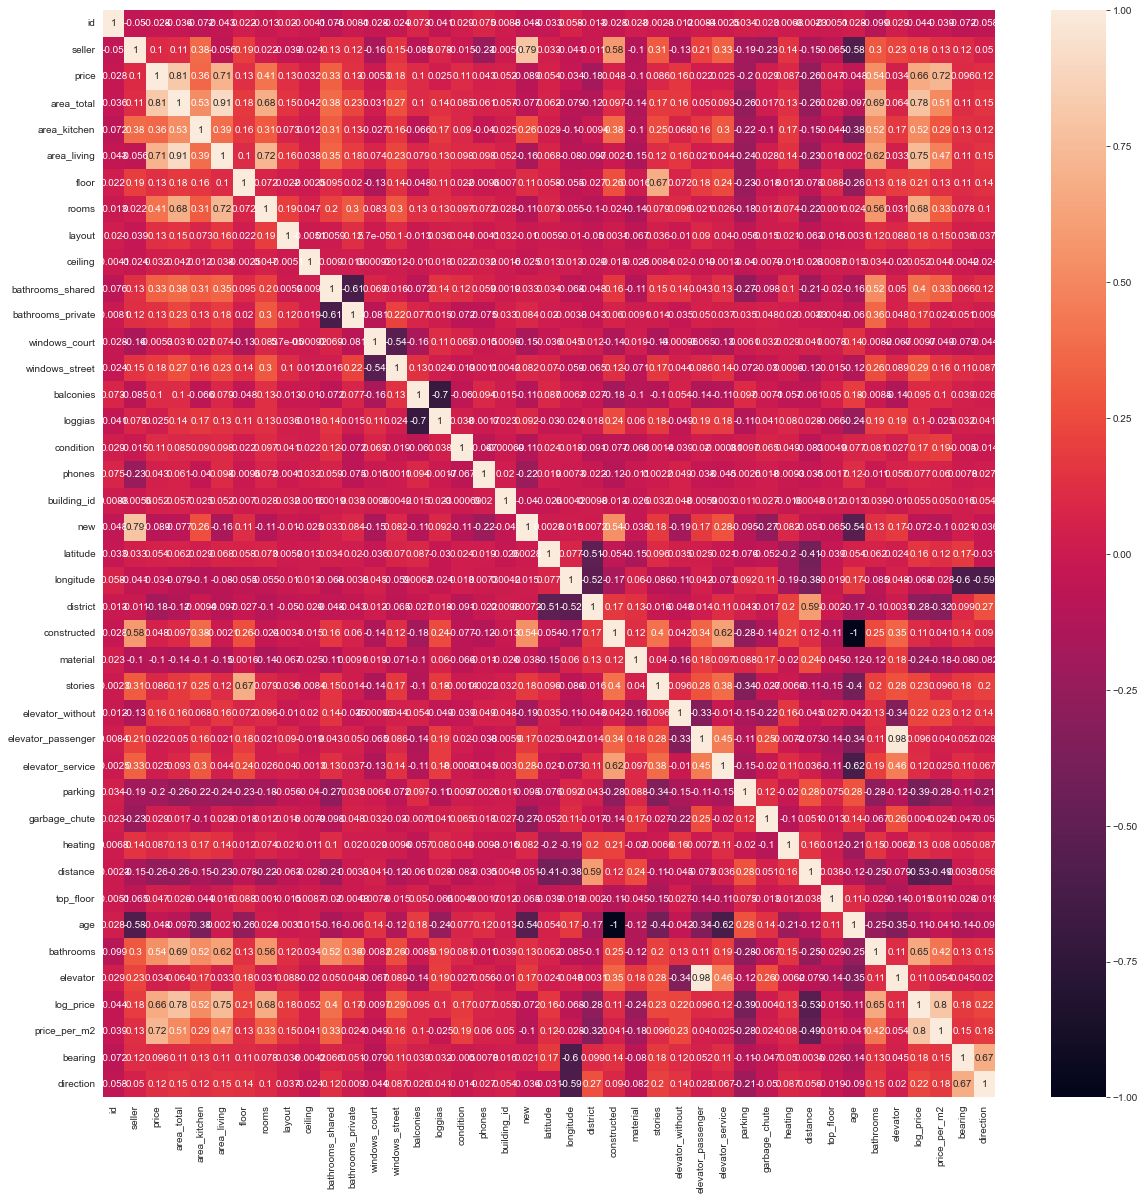

In [141]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True)

**EDA insight:** Correlation between the price and area_total, area_kitchen, area_living, floor, rooms, layout, bathrooms_shared, bathrooms_private, windows_street, balconies, district, material, elevator_without, and parking. However, some correlations may not be as strong as implied due the high number of missing values in some features, such as layout, balconies and condition.

In [142]:
print("Correlation between the price and the other features combined with the number of missing values:")
nan_count = [len(train[train[feature].isna()]) for feature in train.corr()["log_price"].index]
corr_df = pd.DataFrame(
    {
        "corr": train.corr()["log_price"], 
        "nan_count": nan_count,
        "nan_percentage": (np.array(nan_count) / train.shape[0])
    }
).sort_values(by="nan_count", ascending=False)
corr_df

Correlation between the price and the other features combined with the number of missing values:


,corr,nan_count,nan_percentage
layout,0.178670,17642,0.757655
ceiling,0.051916,11093,0.476401
loggias,0.104360,10520,0.451793
balconies,0.094621,10520,0.451793
condition,0.173769,9810,0.421301
seller,0.182874,8830,0.379214
garbage_chute,0.004026,8811,0.378398
heating,0.130949,8161,0.350483
windows_court,-0.009696,8072,0.346661
windows_street,0.289950,8072,0.346661


# Data Cleaning

##  Drop features with very high percentage of nans and low correlation

In [143]:
nan_threshold = 0.3
rel_feats = corr_df[(corr_df.nan_percentage <= nan_threshold) & (corr_df["corr"].abs() > 0.1)]
rel_feats.sort_values(by="corr", ascending=False)

,corr,nan_count,nan_percentage
log_price,1.000000,0,0.000000
price_per_m2,0.801305,0,0.000000
area_total,0.782565,0,0.000000
area_living,0.749629,3882,0.166717
rooms,0.678219,0,0.000000
price,0.664611,0,0.000000
bathrooms,0.651164,3872,0.166287
area_kitchen,0.517461,4721,0.202749
bathrooms_shared,0.396012,3872,0.166287
stories,0.233266,0,0.000000


## Impute Missing Values

### Impute area_living, area_kitchen, and bathrooms using the mean of apartments with similar sizes, i.e., area_total

For buildings with a similar total area, the total living area is presumably about the same. Hence, it would make sense to set the value of the living area to the mean across apartments with a similar total area. The same applies to area_kitchen.

In [144]:
def impute_with_bin_mean(data, feature, bin_feature, bins=40, decimals=0): 
    tr = train.copy()
    te = test.copy()
    database = pd.concat([tr, te])
    database["bin"], bins = pd.cut(database[bin_feature], bins=40, retbins=True)
    pb = 0
    for b in bins:
        bin_data = database[(database[bin_feature] >= pb) & (database[bin_feature] <= b)]
        bin_mean = bin_data[feature].mean()
        percentage = (bin_mean / bin_data[bin_feature]).mean()
        d = data[(data[bin_feature] >= pb) & (data[bin_feature] <= b)]
        ind = d[d[feature].isna()].index
        if pd.notna(bin_mean) and len(ind) > 0:
            bin_mean = round(bin_mean, decimals)
            data.at[ind, feature] = bin_mean
            print("Set {} for {} rows with {} <= area_living <= {} to {}".format(feature, len(ind), pb, b, bin_mean))
        pb = b
    print("Remaining nan values for {}: {}".format(feature, len(data[data[feature].isna()])))
    return data

In [145]:
train_imputed = train.copy()
train_imputed = impute_with_bin_mean(data=train_imputed, feature="area_living", bin_feature="area_total")
train_imputed = impute_with_bin_mean(data=train_imputed, feature="area_kitchen", bin_feature="area_total")
train_imputed = impute_with_bin_mean(data=train_imputed, feature="bathrooms", bin_feature="area_total")
train_imputed = impute_with_bin_mean(data=train_imputed, feature="parking", bin_feature="area_total")

Set area_living for 1581 rows with 7.128300000000001 <= area_living <= 63.5925 to 24.0
Set area_living for 1184 rows with 63.5925 <= area_living <= 117.88499999999999 to 46.0
Set area_living for 647 rows with 117.88499999999999 <= area_living <= 172.1775 to 80.0
Set area_living for 270 rows with 172.1775 <= area_living <= 226.47 to 118.0
Set area_living for 107 rows with 226.47 <= area_living <= 280.7625 to 143.0
Set area_living for 38 rows with 280.7625 <= area_living <= 335.055 to 184.0
Set area_living for 11 rows with 335.055 <= area_living <= 389.34749999999997 to 201.0
Set area_living for 13 rows with 389.34749999999997 <= area_living <= 443.64 to 247.0
Set area_living for 11 rows with 443.64 <= area_living <= 497.9325 to 247.0
Set area_living for 6 rows with 497.9325 <= area_living <= 552.2249999999999 to 361.0
Set area_living for 2 rows with 552.2249999999999 <= area_living <= 606.5174999999999 to 331.0
Set area_living for 3 rows with 606.5174999999999 <= area_living <= 660.81 t

As we can see, some nan_values remain since no values existed in the corresponding bin. These need to be handled differently.

In [146]:
ind = train_imputed[(train_imputed.bathrooms <= 800)].index
train_imputed.at[ind, "bathrooms"] = 5
ind = train_imputed[(train_imputed.bathrooms > 800)].index
train_imputed.at[ind, "bathrooms"] = 6

In [147]:
ind = train_imputed[train_imputed.parking.isna()].index
train_imputed.at[ind, "parking"] = 0

In [148]:
d = train_imputed[train_imputed.area_living.isna()]
for ind, row in d.iterrows():
    train_imputed.at[ind, "area_living"] = 0.85 * row.area_total
    train_imputed.at[ind, "area_kitchen"] = 0.05 * row.area_total

### District
Apartments with missing district will be added to the district: other (12)

In [149]:
ind = train_imputed[train_imputed["district"].isna()].index
train_imputed.at[ind, "district"] = 12
print("#nan in district: {}".format(len(train_imputed[train_imputed["district"].isna()])))

#nan in district: 0


### elevator_without

In [150]:
train_imputed = impute_with_bin_mean(data=train_imputed, feature="elevator_without", bin_feature="stories", bins=20)

Set elevator_without for 18 rows with 0.906 <= area_living <= 3.35 to 1.0
Set elevator_without for 84 rows with 3.35 <= area_living <= 5.7 to 1.0
Set elevator_without for 31 rows with 5.7 <= area_living <= 8.05 to 0.0
Set elevator_without for 59 rows with 8.05 <= area_living <= 10.4 to 0.0
Set elevator_without for 55 rows with 10.4 <= area_living <= 12.75 to 0.0
Set elevator_without for 23 rows with 12.75 <= area_living <= 15.100000000000001 to 0.0
Set elevator_without for 49 rows with 15.100000000000001 <= area_living <= 17.45 to 0.0
Set elevator_without for 8 rows with 17.45 <= area_living <= 19.8 to 0.0
Set elevator_without for 12 rows with 19.8 <= area_living <= 22.150000000000002 to 0.0
Set elevator_without for 4 rows with 22.150000000000002 <= area_living <= 24.5 to 0.0
Set elevator_without for 5 rows with 24.5 <= area_living <= 26.85 to 0.0
Set elevator_without for 1 rows with 26.85 <= area_living <= 29.200000000000003 to 1.0
Set elevator_without for 1 rows with 29.2000000000000

### constructed

In [151]:
d = train_imputed[train_imputed.constructed.isna()]
ind = d[d.new == 1].index
train_imputed.at[ind, "constructed"] = 2021
train_imputed.at[ind, "age"] = 0
print("Remaining nans in constructed: {}".format(len(train_imputed[train_imputed.constructed.isna()])))

Remaining nans in constructed: 681


In [152]:
train_imputed = impute_with_bin_mean(data=train_imputed, feature="constructed", bin_feature="district", bins=12)

Set constructed for 87 rows with -0.011 <= area_living <= 0.275 to 1997.0
Set constructed for 34 rows with 0.8250000000000001 <= area_living <= 1.1 to 2006.0
Set constructed for 38 rows with 1.9250000000000003 <= area_living <= 2.2 to 2003.0
Set constructed for 50 rows with 2.75 <= area_living <= 3.0250000000000004 to 1986.0
Set constructed for 72 rows with 3.8500000000000005 <= area_living <= 4.125 to 2007.0
Set constructed for 74 rows with 4.95 <= area_living <= 5.2250000000000005 to 1999.0
Set constructed for 47 rows with 5.775 <= area_living <= 6.050000000000001 to 1995.0
Set constructed for 41 rows with 6.875000000000001 <= area_living <= 7.15 to 2008.0
Set constructed for 150 rows with 7.9750000000000005 <= area_living <= 8.25 to 2007.0
Set constructed for 12 rows with 8.8 <= area_living <= 9.075000000000001 to 2010.0
Set constructed for 48 rows with 9.9 <= area_living <= 10.175 to 2007.0
Set constructed for 28 rows with 10.725000000000001 <= area_living <= 11.0 to 2018.0
Remaini

In [153]:
d = train_imputed[train_imputed.age.isna()]
for ind, row in d.iterrows():
    train_imputed.at[ind, "age"] = 2021 - row["constructed"]

### material

In [154]:
train_imputed = impute_with_bin_mean(data=train_imputed, feature="material", bin_feature="constructed", bins=20)

Set material for 1 rows with 1897.0 <= area_living <= 1901.2 to 0.0
Set material for 1 rows with 1905.4 <= area_living <= 1909.6 to 1.0
Set material for 8 rows with 1913.8 <= area_living <= 1918.0 to 0.0
Set material for 1 rows with 1918.0 <= area_living <= 1922.2 to 0.0
Set material for 3 rows with 1922.2 <= area_living <= 1926.4 to 0.0
Set material for 6 rows with 1926.4 <= area_living <= 1930.6 to 0.0
Set material for 1 rows with 1930.6 <= area_living <= 1934.8 to 0.0
Set material for 12 rows with 1934.8 <= area_living <= 1939.0 to 0.0
Set material for 2 rows with 1939.0 <= area_living <= 1943.2 to 0.0
Set material for 2 rows with 1947.4 <= area_living <= 1951.6 to 0.0
Set material for 14 rows with 1951.6 <= area_living <= 1955.8 to 0.0
Set material for 71 rows with 1955.8 <= area_living <= 1960.0 to 1.0
Set material for 58 rows with 1960.0 <= area_living <= 1964.2 to 2.0
Set material for 82 rows with 1964.2 <= area_living <= 1968.4 to 3.0
Set material for 59 rows with 1968.4 <= are

### Log Transformation

In [155]:
train_imputed = log_transform(train_imputed, ["area_total", "area_living", "area_kitchen", "distance"])

## One-Hot Encoding of categorical features

In [156]:
district_names = {
    3: "East",
    6: "South-West",
    5: "South",
    4: "South-East",
    0: "Central",
    2: "North-East",
    1: "North",
    8: "North-West",
    7: "West",
    11: "Novomoskovsk",
    10: "Troitsk",
    9: "Zelenograd",
    12: "Other"
}
train_imputed = one_hot_encode(train_imputed, district_names, "district")

In [157]:
directions = {
    0: "N",
    1: "NE",
    2: "E",
    3: "SE",
    4: "S",
    5: "SW",
    6: "W",
    7: "NW"
}
train_imputed = one_hot_encode(train_imputed, directions, "direction")

In [159]:
mat = {
    0: "Bricks",
    1: "Wood",
    2: "Monolith",
    3: "Panel",
    4: "Block",
    5: "Monolithic_brick",
    6: "Stalin_project",
}
train_imputed = one_hot_encode(train_imputed, mat, "material")

In [191]:
print("Correlation between the price and the other features combined with the number of missing values:")
nan_count = [len(train_imputed[train_imputed[feature].isna()]) for feature in train_imputed.corr()["log_price"].index]
corr_df = pd.DataFrame(
    {
        "corr": train_imputed.corr()["log_price"], 
        "nan_count": nan_count,
        "nan_percentage": (np.array(nan_count) / train_imputed.shape[0])
    }
).sort_values(by="nan_count", ascending=False)
nan_threshold = 0
corr_threshold = 0.1
rel_feats = corr_df[(corr_df.nan_percentage <= nan_threshold) & (corr_df["corr"].abs() >= corr_threshold)]
rel_feats.sort_values(by="corr", ascending=False)

Correlation between the price and the other features combined with the number of missing values:


,corr,nan_count,nan_percentage
log_price,1.000000,0,0.0
log_area_total,0.875484,0,0.0
price_per_m2,0.801305,0,0.0
area_total,0.782565,0,0.0
log_area_living,0.747129,0,0.0
area_living,0.694512,0,0.0
rooms,0.678219,0,0.0
price,0.664611,0,0.0
log_area_kitchen,0.583551,0,0.0
area_kitchen,0.579691,0,0.0


In [192]:
features = rel_feats.index
features = features.drop(["price", "log_price", "price_per_m2" ])
features

Index(['Novomoskovsk', 'Central', 'Troitsk', 'West', 'SW', 'E', 'S', 'W',
       'Monolith', 'Panel', 'Block', 'Monolithic_brick', 'South-East', 'East',
       'area_total', 'area_kitchen', 'area_living', 'floor', 'rooms',
       'latitude', 'constructed', 'stories', 'elevator_without', 'parking',
       'distance', 'age', 'elevator', 'bearing', 'log_area_total',
       'log_area_living', 'log_area_kitchen', 'log_distance'],
      dtype='object')

## Outliers

# Training and Model Optimisation

In [193]:
data_train = train_imputed
print(len(data_train))
for feat in features:  
    print("#nan in {}: {}".format(feat, len(train_imputed[train_imputed[feat].isna()])))

23285
#nan in Novomoskovsk: 0
#nan in Central: 0
#nan in Troitsk: 0
#nan in West: 0
#nan in SW: 0
#nan in E: 0
#nan in S: 0
#nan in W: 0
#nan in Monolith: 0
#nan in Panel: 0
#nan in Block: 0
#nan in Monolithic_brick: 0
#nan in South-East: 0
#nan in East: 0
#nan in area_total: 0
#nan in area_kitchen: 0
#nan in area_living: 0
#nan in floor: 0
#nan in rooms: 0
#nan in latitude: 0
#nan in constructed: 0
#nan in stories: 0
#nan in elevator_without: 0
#nan in parking: 0
#nan in distance: 0
#nan in age: 0
#nan in elevator: 0
#nan in bearing: 0
#nan in log_area_total: 0
#nan in log_area_living: 0
#nan in log_area_kitchen: 0
#nan in log_distance: 0


In [194]:
f = features.copy()
f = f.drop(
    [
        "area_kitchen", 
        "area_living",
        "log_area_living", 
        "log_area_kitchen", 
        "log_area_total",
        "log_distance", 
        # "elevator", 
        # "elevator_without",
        # "parking",
        # "stories",
        # "N",
        # "NE",
        # "E",
        # "SE",
        # "S",
        # "SW",
        # "W",
        # "NW",
        # "East",
        # "South-West",
        # "South",
        # "South-East",
        # "Central",
        # "North-East",
        # "North",
        # "North-West",
        # "West",
        # "Novomoskovsk",
        # "Troitsk",
        # "Zelenograd",
        # "bearing",
        # "top_floor",
        # "Other",
        # "latitude",
        # "longitude",
        # "area_total",
        # "rooms",
        # "floor"
    ]
)


In [222]:
from sklearn.model_selection import train_test_split

X = data_train[f]
y = data_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
y_train_rf = data_train.loc[X_train.index]["price_per_m2"]
y_val_rf = data_train.loc[X_val.index]["price_per_m2"]
y_train_lgbm = data_train.loc[X_train.index]["log_price"]
y_val_lgbm = data_train.loc[X_val.index]["log_price"]

In [223]:
from sklearn.metrics import mean_squared_log_error

def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Valid rmsle: 0.1265


Text(0, 0.5, 'Ground Truth')

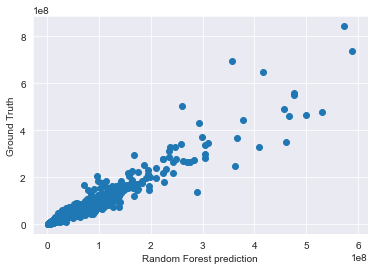

In [224]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(
    n_estimators=200,
    criterion='mse',
    n_jobs=2,
    random_state=42,
)
rf_reg.fit(X_train, y_train_rf)


rf_train_pred = rf_reg.predict(X_train)
rf_val_pred = rf_reg.predict(X_val)
rf_val_pred *= X_val.area_total
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=rf_val_pred) :.4f}')

plt.scatter(rf_val_pred, y_val)
plt.xlabel('Random Forest prediction')
plt.ylabel('Ground Truth')

Valid rmsle: 0.1246


Text(0, 0.5, 'Ground Truth')

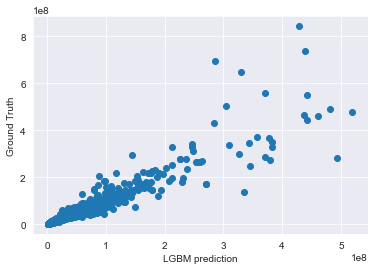

In [225]:
import lightgbm as lgbm

lgbm_reg = lgbm.LGBMRegressor(
    random_state=42,
    learning_rate=0.1,
    n_estimators=2000,
    boosting_type='gbdt',
    n_jobs=2,
    num_leaves=35
)

lgbm_reg.fit(X_train, y_train_lgbm)

lgbm_pred = lgbm_reg.predict(X_val)
lgbm_pred = (np.e ** lgbm_pred) - 1
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=lgbm_pred) :.4f}')

plt.scatter(lgbm_pred, y_val)
plt.xlabel('LGBM prediction')
plt.ylabel('Ground Truth')

In [226]:
from catboost import CatBoostRegressor
cb = CatBoostRegressor(
    n_estimators=2000,
    learning_rate=0.2,
    thread_count=-1,
    depth=7,
    silent=True,
    random_seed=42,
    bagging_temperature=0.2
)

cb.fit(X_train, y_train_lgbm)
cb_pred = cb.predict(X_val)
cb_pred = (np.e ** cb_pred) - 1
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=cb_pred) :.4f}')

Valid rmsle: 0.1244


## Averaging

Valid rmsle: 0.1187


Text(0, 0.5, 'Ground Truth')

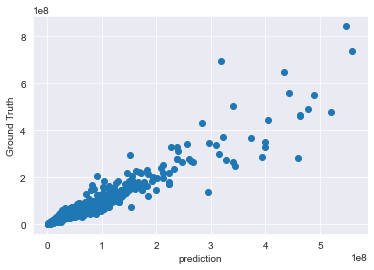

In [227]:
avg_prediction = np.mean([rf_val_pred, lgbm_pred, cb_pred], axis=0)
print(f'Valid rmsle: {root_mean_squared_log_error(y_true=y_val, y_pred=avg_prediction) :.4f}')
plt.scatter(avg_prediction, y_val)
plt.xlabel('prediction')
plt.ylabel('Ground Truth')

# Prediction

In [57]:
ind = test[test["longitude"].isna()].index
test.at[ind, "latitude"] = 55.56776345324702
test.at[ind, "longitude"] = 37.48171529826662

In [58]:
data_test = test.copy()
data_test = construct_features(data_test)
data_test = compute_directional_data(data_test)
data_test = impute_with_bin_mean(data=data_test, feature="area_living", bin_feature="area_total", bins=40)
data_test = impute_with_bin_mean(data=data_test, feature="area_kitchen", bin_feature="area_total", bins=40)
data_test = impute_with_bin_mean(data=data_test, feature="bathrooms", bin_feature="area_total", bins=40)
data_test = impute_with_bin_mean(data=data_test, feature="parking", bin_feature="area_total", bins=40)

Set area_living for 834 rows with 7.128300000000001 <= area_living <= 63.5925 to 24.0
Set area_living for 704 rows with 63.5925 <= area_living <= 117.88499999999999 to 46.0
Set area_living for 286 rows with 117.88499999999999 <= area_living <= 172.1775 to 80.0
Set area_living for 117 rows with 172.1775 <= area_living <= 226.47 to 118.0
Set area_living for 33 rows with 226.47 <= area_living <= 280.7625 to 143.0
Set area_living for 20 rows with 280.7625 <= area_living <= 335.055 to 184.0
Set area_living for 9 rows with 335.055 <= area_living <= 389.34749999999997 to 201.0
Set area_living for 9 rows with 389.34749999999997 <= area_living <= 443.64 to 247.0
Set area_living for 3 rows with 443.64 <= area_living <= 497.9325 to 247.0
Set area_living for 1 rows with 497.9325 <= area_living <= 552.2249999999999 to 361.0
Set area_living for 1 rows with 552.2249999999999 <= area_living <= 606.5174999999999 to 331.0
Set area_living for 2 rows with 606.5174999999999 <= area_living <= 660.81 to 363.

In [59]:
print(data_test[data_test["area_living"].isna()]["area_total"])
print(data_test[data_test["area_kitchen"].isna()]["area_total"])
print(data_test[data_test["bathrooms"].isna()]["area_total"])

Series([], Name: area_total, dtype: float64)
3496    1050.0
Name: area_total, dtype: float64
3496    1050.0
7931     732.0
Name: area_total, dtype: float64


In [60]:
d = data_test[data_test.area_kitchen.isna()]
for ind, row in d.iterrows():
    data_test.at[ind, "area_kitchen"] = 0.05 * row.area_total

In [61]:
bath_nan = data_test[data_test.bathrooms.isna()]
ind = bath_nan[(bath_nan.area_total <= 800)].index
data_test.at[ind, "bathrooms"] = 5
ind = bath_nan[(bath_nan.area_total > 800)].index
data_test.at[ind, "bathrooms"] = 6

In [62]:
ind = data_test[data_test["district"].isna()].index
data_test.at[ind, "district"] = 12

In [63]:
ind = data_test[data_test["parking"].isna()].index
data_test.at[ind, "parking"] = 0

In [64]:
data_test = impute_with_bin_mean(data=data_test, feature="elevator_without", bin_feature="stories", bins=20)

Set elevator_without for 8 rows with 0.906 <= area_living <= 3.35 to 1.0
Set elevator_without for 39 rows with 3.35 <= area_living <= 5.7 to 1.0
Set elevator_without for 13 rows with 5.7 <= area_living <= 8.05 to 0.0
Set elevator_without for 31 rows with 8.05 <= area_living <= 10.4 to 0.0
Set elevator_without for 30 rows with 10.4 <= area_living <= 12.75 to 0.0
Set elevator_without for 15 rows with 12.75 <= area_living <= 15.100000000000001 to 0.0
Set elevator_without for 28 rows with 15.100000000000001 <= area_living <= 17.45 to 0.0
Set elevator_without for 3 rows with 17.45 <= area_living <= 19.8 to 0.0
Set elevator_without for 5 rows with 19.8 <= area_living <= 22.150000000000002 to 0.0
Set elevator_without for 6 rows with 22.150000000000002 <= area_living <= 24.5 to 0.0
Set elevator_without for 1 rows with 24.5 <= area_living <= 26.85 to 0.0
Set elevator_without for 1 rows with 36.25 <= area_living <= 38.6 to 1.0
Remaining nan values for elevator_without: 0


In [65]:
district_names = {
    3: "East",
    6: "South-West",
    5: "South",
    4: "South-East",
    0: "Central",
    2: "North-East",
    1: "North",
    8: "North-West",
    7: "West",
    11: "Novomoskovsk",
    10: "Troitsk",
    9: "Zelenograd",
    12: "Other"
}
data_test = one_hot_encode(data_test, district_names, "district")

In [66]:
directions = {
    0: "N",
    1: "NE",
    2: "E",
    3: "SE",
    4: "S",
    5: "SW",
    6: "W",
    7: "NW"
}
data_test = one_hot_encode(data_test, directions, "direction")

In [67]:
r = {
    "distance": "log_distance",
    "area_total": "log_area_total"
}
for k, v in r.items():
    data_test[v] = np.log1p(data_test[k])

In [68]:
for feat in f:  
    print("#nan in {}: {}".format(feat, len(data_test[data_test[feat].isna()])))

#nan in North-West: 0
#nan in North-East: 0
#nan in North: 0
#nan in Central: 0
#nan in South-East: 0
#nan in South: 0
#nan in South-West: 0
#nan in East: 0
#nan in Zelenograd: 0
#nan in West: 0
#nan in Novomoskovsk: 0
#nan in Troitsk: 0
#nan in Other: 0
#nan in N: 0
#nan in NE: 0
#nan in E: 0
#nan in SE: 0
#nan in S: 0
#nan in SW: 0
#nan in W: 0
#nan in top_floor: 0
#nan in area_total: 0
#nan in floor: 0
#nan in rooms: 0
#nan in latitude: 0
#nan in longitude: 0
#nan in stories: 0
#nan in elevator_without: 0
#nan in parking: 0
#nan in distance: 0
#nan in bearing: 0
#nan in NW: 0


In [72]:
X_test = data_test[f]
rf_pred = rf_reg.predict(X_test)
rf_pred *= X_test.area_total
lgbm_pred = lgbm_reg.predict(X_test)
lgbm_pred = (np.e ** lgbm_pred) - 1
pred = np.mean([rf_pred, lgbm_pred], axis=0)

In [73]:
submission = pd.DataFrame()
submission['id'] = data_test.id
submission['price_prediction'] = pred
submission.to_csv('submission.csv', index=False)

print('\nLine count of submission')
!wc -l submission.csv

print('\nFirst 5 rows of submission')
!head -n 5 submission.csv


Line count of submission
    9938 submission.csv

First 5 rows of submission
id,price_prediction
23285,34117491.7410291
23286,7913127.97595478
23287,6102201.38851375
23288,8750051.594091253
